# Import libraries

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Create corpus

In [2]:
root_dir = "/kaggle/input/poemsdataset/topics"
corpus = []
corpus_size = 10000
done = False

print("Loading poems in corpus...\n")
for dirname, _, filenames in os.walk(root_dir):
    if done: break
    print(f"Loading {dirname}")
    for filename in filenames:
        if done: break
        with open(os.path.join(dirname, filename), "r") as file:
            txt = file.read()
            for line in txt.split("\n"):
                if done: break
                corpus.append(line)
                if len(corpus) == corpus_size:
                    done = True

Loading poems in corpus...

Loading /kaggle/input/poemsdataset/topics
Loading /kaggle/input/poemsdataset/topics/moon
Loading /kaggle/input/poemsdataset/topics/beauty
Loading /kaggle/input/poemsdataset/topics/joy
Loading /kaggle/input/poemsdataset/topics/hero


In [3]:
len(corpus)

10000

In [4]:
corpus[:10]

["Press'd by the Moon, mute arbitress of tides,",
 'While the loud equinox its power combines,',
 'The sea no more its swelling surge confines,',
 "But o'er the shrinking land sublimely rides.",
 'The wild blast, rising from the Western cave,',
 'Drives the huge billows from their heaving bed;',
 'Tears from their grassy tombs the village dead,',
 'And breaks the silent sabbath of the grave!',
 'With shells and sea-weed mingled, on the shore',
 'Lo! their bones whiten in the frequent wave;']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [5]:
import string

def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

corpus = [ remove_punc(s.lower().strip()) for s in corpus ]

In [6]:
corpus[:10]

['pressd by the moon mute arbitress of tides',
 'while the loud equinox its power combines',
 'the sea no more its swelling surge confines',
 'but oer the shrinking land sublimely rides',
 'the wild blast rising from the western cave',
 'drives the huge billows from their heaving bed',
 'tears from their grassy tombs the village dead',
 'and breaks the silent sabbath of the grave',
 'with shells and seaweed mingled on the shore',
 'lo their bones whiten in the frequent wave']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9340


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [9]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 58453
Maximum n-gram length: 262


In [10]:
for n_gram in n_grams[:10]:
    print(n_gram)

[4218, 42]
[4218, 42, 1]
[4218, 42, 1, 33]
[4218, 42, 1, 33, 1014]
[4218, 42, 1, 33, 1014, 4219]
[4218, 42, 1, 33, 1014, 4219, 3]
[4218, 42, 1, 33, 1014, 4219, 3, 1325]
[150, 1]
[150, 1, 914]
[150, 1, 914, 4220]


## Pad n-grams

In [11]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(58453, 100)

In [12]:
for seq in padded_n_grams[:3]:
    print(seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 4218   42]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

## Split n-grams into X and y

In [13]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (58453, 99)
y: (58453,)


In [14]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (58453, 9340)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [15]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 300)           2802000   
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 9340)              1410340   
                                                                 
Total params: 4,482,940
Trainable params: 4,482,940
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(
    X, 
    y, 
    epochs=200,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/200
457/457 [==============================] - 45s 89ms/step - loss: 7.2758 - accuracy: 0.0512
Epoch 2/200
457/457 [==============================] - 12s 27ms/step - loss: 6.7635 - accuracy: 0.0722
Epoch 3/200
457/457 [==============================] - 10s 23ms/step - loss: 6.5075 - accuracy: 0.0842
Epoch 4/200
457/457 [==============================] - 10s 23ms/step - loss: 6.3137 - accuracy: 0.0908
Epoch 5/200
457/457 [==============================] - 9s 21ms/step - loss: 6.1336 - accuracy: 0.0990
Epoch 6/200
457/457 [==============================] - 9s 20ms/step - loss: 5.9613 - accuracy: 0.1066
Epoch 7/200
457/457 [==============================] - 8s 18ms/step - loss: 5.7910 - accuracy: 0.1151
Epoch 8/200
457/457 [==============================] - 8s 17ms/step - loss: 5.6167 - accuracy: 0.1249
Epoch 9/200
457/457 [==============================] - 8s 18ms/step - loss: 5.4373 - accuracy: 0.1348
Epoch 10/200
457/457 [==============================] - 8s 18ms/step - loss: 5

# Plot learning curves

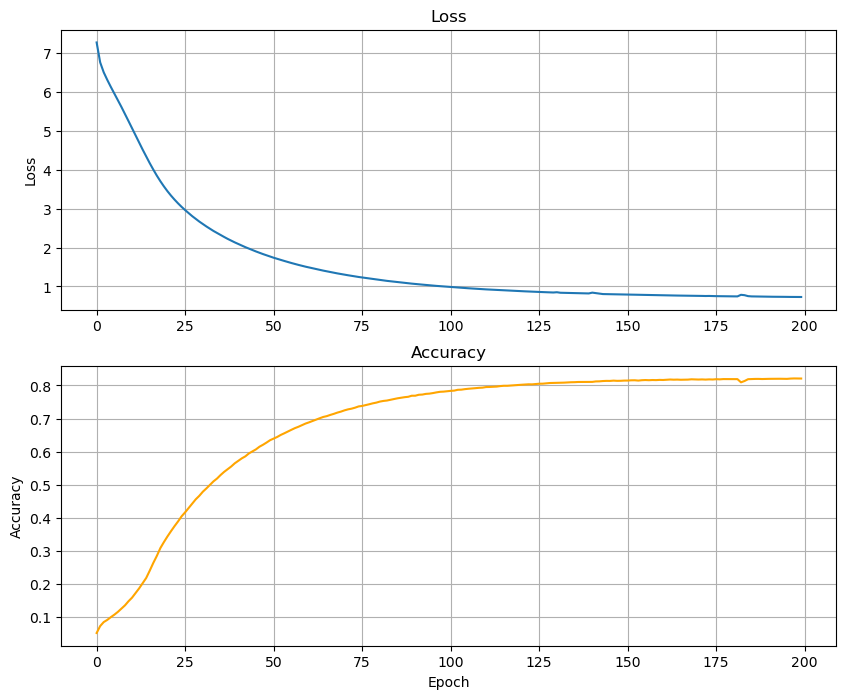

In [17]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [18]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [19]:
generate("Hello there", 200)

Hello there for you on my riverbank heart my feet again to wait the day i wooed and loved with sorrow at evening when you see to the best of all ways i am in her will to die into to kill the yanquis with big bomb i can bless you stink like a sneaker pal i peel off one of my pumps and throw it in the direction of his fat head then i get the hell out of there i am i think the ever will she would i let go go or into all which it is her own life and the flowers shone upon the moonlit war i express the end of the awe other there was the best and all her light and my distress and now shall sing of your my son and the my my he called the villain the ever virgin into your wing attached to a claw and the story is a beauty i express it always be you look at you and me to know how to a your beauty rose makes for a bud on the intercom and the story is a beauty i express it always her sound you can


In [20]:
generate("It was a wonderful time", 200)

It was a wonderful time to keep that if the moon was my tears run down in shore and down the chalkboard of the city on the story is the villain ends the road her into the domain of the valley thats its into the time she then told it her her my son upon the passion to pleasing orange i returned to the trees prevented the sun from the touching the earth once more over the holy you hear them she and the vague which you understand and the mute which you hear it is the holy of holies that begins in yourself and ends vastly beyond your earthly imagination as sing and i shall see the i was the hell a her from the spacious alley i pursued the beckoning course of the rivulet and the musical sounds of the birds until i reached a lonely spot where the flowing branches of the trees prevented the sun from the touching the earth once stop our her into the line full shot thou vouchsafe i sorrow shadow across the lot remains beauty within the lot remains i can fly without feathers at the spring leapin

In [21]:
generate("In a town of Athy one Jeremy Lanigan", 200)

In a town of Athy one Jeremy Lanigan eternal truth you at last he died i can and always thought have gone to know what to fly me i wont flinch till nine great love to his may let it so dear you know me with you forevermore there to your way thy light was done me with my flowers my he called the villain the time she let us of things than – and now did we see it is to fly and i go down or indeed have hurled her there you saved me to eat light if when she got i press no control of your rents and i shall tell you faithfully you from your own hero and he once i dont let go out you so much i am i the beauty there i can go somewhere you so politely i needed a haircut gnome of her but few blest be down up now by her naked body and i will i read it it then took a time of my adoring ancestors became a part of the earth nothing was left to commemorate their goddess save a pitiful few and the forgotten pages in the book of history it often see that


In [22]:
generate("I made a poetry machine", 200)

I made a poetry machine won’t allow me to reply tonight her whose breath and its dear proud so there of thee and all my nymph was most time when life is sophisticated and even in my flowers my my life my he was the trees prevented the sun from the touching the earth once even over the i was the hell a her she then my work i will meet your mistakes when i was steering that car i was swerving but i had her to correct my mistakes her correcting them for me while i was by her side i learned it a lot faster then i would of on my own now we arent that close to each other and i started to forget what she taught me that one day i didnt like how i was treating other people and i thought about stuff to be a better person i thought and thought about it and i remembered what she did for me i was changing a little at a time there was a lot more then what i wrote in this story i dont know how to thank her maybe this story will do more than i think thank you


In [23]:
generate("I don't know",200)

I don't know we argue going nor leave and your joy and i will lead me to your first joy i now but i cannot fully relinquish her alone there so much is marvelled more or less by degrees salon and looked so much tears of joy in peace to express or most most run as there she cannot express my head my need thee smiling in lay clear there was left what to soar at first heart and the roaring my tears my dear my he called the villain the ever virgin your forefathers worshipped and there was a lonely spot where a well her place me soon in couples fly to god and i remembered what she did for me i was changing a little at a time there was a lot more then what i wrote in this story i dont know how to thank her maybe this story the wound is clean and in my i my her store my need held as in a alone she came to cope and goes fall and kissing his heart and they which your hero isnt left to their lives near here i send to his my dear my he called the


That's some interesting poetry!